In [13]:
from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, poisson
from msgan import GeneratorNet, DiscriminatorNet, MSGAN
%matplotlib inline

## Load Data

In [30]:
class GaussianImageDataset(Dataset):
    def __init__(self, mean=[14, 14], cov=[[10, 0], [0, 10]], n_pixel=(28, 28), transform=None, n_samples=1000):
        self.transform = transform
        self.n_samples = n_samples


        XY = np.meshgrid(np.arange(28), np.arange(28), )
        mesh = np.array(XY).T.reshape(28*28, 2)
        seeds = multivariate_normal.pdf(x=mesh, mean=mean, cov=cov)

        scale = 3000
        seeds = np.tile(seeds, n_samples) * scale
        d  = poisson.rvs(mu=seeds).reshape(n_samples, n_pixel[0], n_pixel[1]).astype(np.float32)
        self.data = d/d.max()
        

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        sample = self.data[idx, :, :]
        if self.transform:
            sample = self.transform(sample)
        return sample
    


In [31]:
# Load data
data = GaussianImageDataset(n_samples=50000)
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)
# Num batches
num_batches = len(data_loader)

def noise(size):
    n = Variable(torch.randn(size, generator.n_input))
    if torch.cuda.is_available():
        return n.cuda 
    return n


## Networks

In [32]:
discriminator = DiscriminatorNet(hidden_sizes=[256, 128, 64])
generator = GeneratorNet(hidden_sizes=[64, 128, 256])

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

    # Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

gan = MSGAN(generator, discriminator, g_optimizer, d_optimizer)


print(f'Cuda Avilable? : {torch.cuda.is_available()}')

Cuda Avilable? : False


## Optimization

In [33]:

loss_on_real_data = []
loss_on_fake_data = []
generator_loss = []

num_epochs = 4
for epoch in tqdm_notebook(range(num_epochs)):
    loss_real, loss_fake, g_loss = gan.fit(data_generator=data_loader, noise_generator=noise)
    loss_on_real_data.append(loss_real)
    loss_on_fake_data.append(loss_fake)
    generator_loss.append(g_loss)
    
loss_on_real_data = np.array(loss_on_real_data).ravel()
loss_on_fake_data = np.array(loss_on_fake_data).ravel()
generator_loss = np.array(generator_loss).ravel()

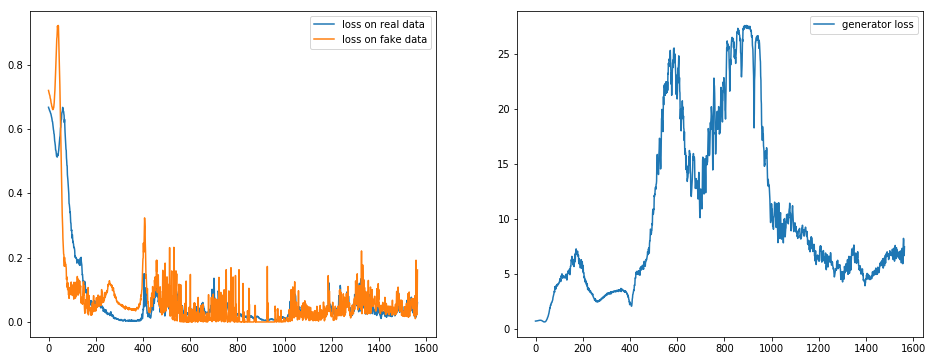

In [34]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(loss_on_real_data, label='loss on real data')
ax1.plot(loss_on_fake_data, label='loss on fake data')
ax1.legend()

ax2.plot(generator_loss, label='generator loss')
ax2.legend()


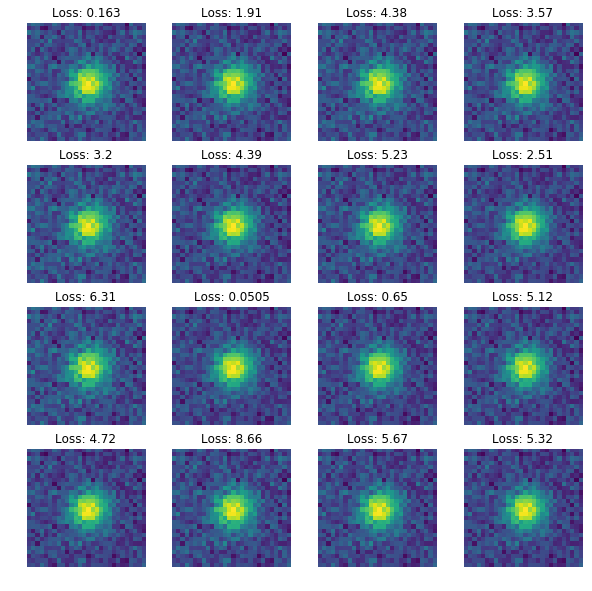

In [37]:
import numpy as np
import matplotlib.pyplot as plt
test_image = generator(noise(16))
images = np.array(test_image.data).reshape(16, 28, 28)

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for img, ax in zip(images, axs.ravel()):
    m = ax.imshow(img)
    ax.axis('off')
#     fig.colorbar(m, ax=ax)
    d = discriminator(torch.Tensor(img.ravel()))
    ax.set_title(f'Loss: {float(loss(d, torch.ones(1))):.3}')

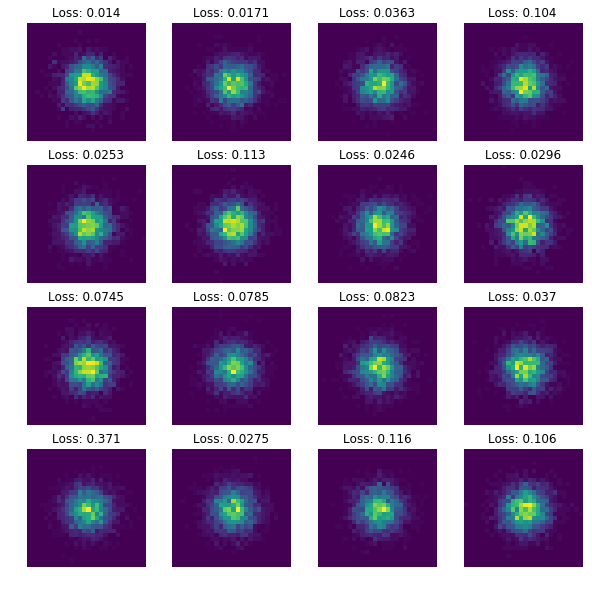

In [38]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

batch = next(iter(data_loader))
for img, ax in zip(batch, axs.ravel()):
    ax.imshow(img[:, :])
    ax.axis('off')
    img = img.view(28*28)
    d = discriminator(torch.Tensor(img))
    l = loss(d, torch.ones(1))

    ax.set_title(f'Loss: {float(l):.3}')